# Capstone 2 Modeling

In this notebook I'm going to prepare and evaluate several different models. Each model will be run across a range of hyperparameter values. Also, each model will be applied to 4 sets of outcome and predictor variables. I'll predict DNAtype based on amino acids, DNAtype based on codons, kingdom based on amino acids, and kingdom based on codons. Incorporating both the amino acid and codon data in a single model would be unwarranted, as the amino acid frequencies are linear combinations of the codon frequencies.  I'll begin with some imports:

In [1]:
import pandas as pd
import numpy as np
import xgboost as xg
import matplotlib.pyplot as plt
import hyperopt
from hyperopt import hp
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_curve, f1_score, auc, accuracy_score, log_loss, classification_report,confusion_matrix,roc_curve,roc_auc_score
import shap
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')



In [2]:
codon_list = ['UUU', 'UUC', 'UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG',
       'AUU', 'AUC', 'AUA', 'AUG', 'GUU', 'GUC', 'GUA', 'GUG', 'GCU', 'GCC',
       'GCA', 'GCG', 'CCU', 'CCC', 'CCA', 'CCG', 'UGG', 'GGU', 'GGC', 'GGA',
       'GGG', 'UCU', 'UCC', 'UCA', 'UCG', 'AGU', 'AGC', 'ACU', 'ACC', 'ACA',
       'ACG', 'UAU', 'UAC', 'CAA', 'CAG', 'AAU', 'AAC', 'UGU', 'UGC', 'CAU',
       'CAC', 'AAA', 'AAG', 'CGU', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG', 'GAU',
       'GAC', 'GAA', 'GAG', 'UAA', 'UAG', 'UGA']

amino_list = ['alanine', 'arginine',
       'asparagine', 'aspartic acid', 'cysteine', 'glutamine', 'glutamic acid',
       'glycine', 'histidine', 'isoleucine', 'leucine', 'lysine', 'methionine',
       'phenylalanine', 'proline', 'serine', 'threonine', 'tryptophan',
       'tyrosine', 'valine', 'start', 'stop']

In [3]:
dnacols = ['D_chloroplast', 'D_genomic', 'D_mitochondrial']
kingcols = ['K_bacteria', 'K_virus', 'K_plant', 'K_vertebrate', 'K_invertebrate',
            'K_mammal', 'K_bacteriophage', 'K_rodent', 'K_primate', 'K_archaea']


In [4]:
# importing the csv from the preprocessing notebook
cu = pd.read_csv('codon_usage3.csv', index_col='Unnamed: 0')
cu.head()

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,K_plant,K_primate,K_rodent,K_vertebrate,K_virus,D_chloroplast,D_genomic,D_mitochondrial,KingLabel,DNALabel
0,virus,genomic,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0,0,0,0,1,0,1,0,9,1
1,virus,genomic,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0,0,0,0,1,0,1,0,9,1
2,virus,genomic,100755,4862,Sweet potato leaf curl virus,0.01974,0.02180,0.01357,0.01543,0.00782,...,0,0,0,0,1,0,1,0,9,1
3,virus,genomic,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0,0,0,0,1,0,1,0,9,1
4,virus,genomic,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0,0,0,0,1,0,1,0,9,1


In [5]:
# am having some problems with NA popping up after train_test_split!
cu.isna().sum().sum()

0

In [6]:
list(cu.columns)

['Kingdom',
 'DNAtype',
 'SpeciesID',
 'Ncodons',
 'SpeciesName',
 'UUU',
 'UUC',
 'UUA',
 'UUG',
 'CUU',
 'CUC',
 'CUA',
 'CUG',
 'AUU',
 'AUC',
 'AUA',
 'AUG',
 'GUU',
 'GUC',
 'GUA',
 'GUG',
 'GCU',
 'GCC',
 'GCA',
 'GCG',
 'CCU',
 'CCC',
 'CCA',
 'CCG',
 'UGG',
 'GGU',
 'GGC',
 'GGA',
 'GGG',
 'UCU',
 'UCC',
 'UCA',
 'UCG',
 'AGU',
 'AGC',
 'ACU',
 'ACC',
 'ACA',
 'ACG',
 'UAU',
 'UAC',
 'CAA',
 'CAG',
 'AAU',
 'AAC',
 'UGU',
 'UGC',
 'CAU',
 'CAC',
 'AAA',
 'AAG',
 'CGU',
 'CGC',
 'CGA',
 'CGG',
 'AGA',
 'AGG',
 'GAU',
 'GAC',
 'GAA',
 'GAG',
 'UAA',
 'UAG',
 'UGA',
 'alanine',
 'arginine',
 'asparagine',
 'aspartic acid',
 'cysteine',
 'glutamine',
 'glutamic acid',
 'glycine',
 'histidine',
 'isoleucine',
 'leucine',
 'lysine',
 'methionine',
 'phenylalanine',
 'proline',
 'serine',
 'threonine',
 'tryptophan',
 'tyrosine',
 'valine',
 'start',
 'stop',
 'K_archaea',
 'K_bacteria',
 'K_bacteriophage',
 'K_invertebrate',
 'K_mammal',
 'K_plant',
 'K_primate',
 'K_rodent',
 'K_ver

In [8]:
cu['KingLabel'].value_counts()

1    2918
9    2832
5    2490
8    2077
3    1333
4     572
2     220
7     215
6     180
0     126
Name: KingLabel, dtype: int64

In [9]:
# it could be useful to store the results for all of these models 
# some of these will be dict()s - which may be a challenge, but seems like the best solution
# I hate having model_id as a column but I see no good alternative

r_cols = ['model_id', 'model_type', 'inputs', 'outputs', 'hyperparameters', 'assessment', 'start_time', 'run_time'] 
results = pd.DataFrame(columns = r_cols)

results


,model_id,model_type,inputs,outputs,hyperparameters,assessment,start_time,run_time


## Principal Component Analysis

component: 1 var exp: 0.3601442991564961
component: 2 var exp: 0.22580436696209108
component: 3 var exp: 0.06282672183163526
component: 4 var exp: 0.037815074438060994
component: 5 var exp: 0.028781137438589104
component: 6 var exp: 0.022230087970430377
component: 7 var exp: 0.02110601540211131
component: 8 var exp: 0.01795869889201909
0.7766664020914333


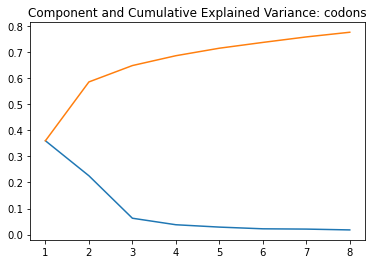

In [10]:
# it could also be interesting at this stage to try PCA:

c = 8
pca = PCA(n_components=c)
pca_fit = pca.fit_transform(cu[codon_list].values)

plt.plot(range(1,c+1), pca.explained_variance_ratio_)
plt.plot(range(1,c+1), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component and Cumulative Explained Variance: codons")

for i in range(0,c):
    print('component:', i+1, 'var exp:', pca.explained_variance_ratio_[i])

print(sum(pca.explained_variance_ratio_))

I neglected to use StandardScaler() first. It's interesting to see just how much these variance components are inflated in the absence of standardization.  Let's try again.

component: 1 var exp: 0.2979106347251203
component: 2 var exp: 0.1866515516669117
component: 3 var exp: 0.05561274755708531
component: 4 var exp: 0.04028130661849915
component: 5 var exp: 0.03458767210079254
component: 6 var exp: 0.029795268401390206
component: 7 var exp: 0.02318935980837632
component: 8 var exp: 0.022103620878174326
0.6901321617563498


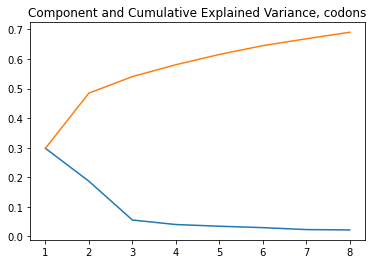

In [11]:
ss = StandardScaler()
codon_ss = ss.fit_transform(cu[codon_list])

c = 8
pca = PCA(n_components=c)
pca_fit = pca.fit_transform(codon_ss)

plt.plot(range(1,c+1), pca.explained_variance_ratio_)
plt.plot(range(1,c+1), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component and Cumulative Explained Variance, codons")

for i in range(0,c):
    print('component:', i+1, 'var exp:', pca.explained_variance_ratio_[i])

print(sum(pca.explained_variance_ratio_))

In [ ]:
# let's also try this on aminos

ss = StandardScaler()
amino_ss = ss.fit_transform(cu[amino_list])

c = 8
pca = PCA(n_components=c)
pca_fit = pca.fit_transform(amino_ss)

plt.plot(range(1,c+1), pca.explained_variance_ratio_)
plt.plot(range(1,c+1), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component and Cumulative Explained Variance, aminos")

for i in range(0,c):
    print('component:', i+1, 'var exp:', pca.explained_variance_ratio_[i])

print(sum(pca.explained_variance_ratio_))

If we apply the 'elbow method' as one might in, say, k-means clustering, it suggests that applying models to just 3 principal components might be useful.  Still, this only explains only 69% of the variance - if we extend this graph to many components, it has a very long tail.  I'm unconvinced that it would really be beneficial to apply some kind of dimensionality reduction.  But I might return to this later.

# Applying some ML models

I'm going to begin by setting aside a split for final testing across all models.  Because the models are being tested against four conditions (predicting DNAtype and kingdom by aminos and codons) this is a bit complicated.  Instead of creating four separate test split sets (each with X_test and y_test) I'm going to create a test set dataframe.


In [18]:
# I'm going to store the training splits in the original cu dataframe to avoid having to recode everything.
# But I'd like to retain the complete dataframe, it might prove useful.

cufull=cu
cufull.head()

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,K_plant,K_primate,K_rodent,K_vertebrate,K_virus,D_chloroplast,D_genomic,D_mitochondrial,KingLabel,DNALabel
0,virus,genomic,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0,0,0,0,1,0,1,0,9,1
1,virus,genomic,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0,0,0,0,1,0,1,0,9,1
2,virus,genomic,100755,4862,Sweet potato leaf curl virus,0.01974,0.02180,0.01357,0.01543,0.00782,...,0,0,0,0,1,0,1,0,9,1
3,virus,genomic,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0,0,0,0,1,0,1,0,9,1
4,virus,genomic,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0,0,0,0,1,0,1,0,9,1


In [19]:
# there were some problems with NaN's appearing for some reason
cufull.isna().sum().sum()

0

In [20]:
all_X = codon_list + amino_list + ['Ncodons']
all_Y = kingcols + dnacols + ['Kingdom', 'DNAtype', 'KingLabel', 'DNALabel']
testset = pd.DataFrame(columns = all_X + all_Y)
cu = pd.DataFrame(columns = all_X + all_Y)
cu[all_X], testset[all_X], cu[all_Y], testset[all_Y] = train_test_split(cufull[all_X], cufull[all_Y], test_size=0.15, random_state=1371)



In [21]:
cu.shape

(11018, 104)

In [22]:
testset.shape

(1945, 104)

In [23]:
cu.isna().sum().sum()

0

In [24]:
testset.isna().sum().sum()

0

Finally this checks out - I was having a persistent problem with NaN's appearing after the split.  It's not happening now, but I have no idea what was producing them.

### K-Nearest Neighbors

K-NN might not be the model type most likely to prove useful, but it has only a single hyperparameter (k, the number of neighbors) to consider.  I'll incorporate everything I need to do into a simple function, this will help avoid tragic mistakes and simplify the work.

In [ ]:
def tvts(X, y, val_p=0.15, test_p=0.15, rand=0):
    '''Three way train-validation-test split function'''
    first_split = val_p + test_p
    second_split = test_p / first_split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=first_split, random_state=rand)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=second_split, random_state=rand+1)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
# test it
outs = tvts(cu[amino_list], cu[kingcols])

In [ ]:
for out in outs:
    print(len(out))

Seems to work.

In [15]:
def scale_all(X_train, X_val, X_test):
    '''uses StandardScaler() to fit_transform X_train, and then transform X_val and X_test'''
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_val = ss.transform(X_val)
    X_test = ss.transform(X_test)
    return X_train, X_val, X_test


In [16]:
def scale_tv(X_train, X_val):
    '''uses StandardScaler() to fit_transform X_train and transform X_val'''
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_val = ss.transform(X_val)
    return X_train, X_val

In [ ]:
'''It is EXTREMELY PAINFUL to me that it proved necessary to include Xn and yn to represent the NAMES of the 
parameters X and y in the function below.  I looked long and hard and ultimately in vain for a clean, simple way
to obtain the name of a variable as a string.  Perhaps this is possible, but I was more concerned about getting
the function to work.''' 

def knn_fit(y, X, yn='', Xn='', max_k=8, tts_random_state=0, test_id=0, do_plots=False):
    '''Fits a k-nearest neighbors model and returns to results dataframe.'''
    # split all data
    X_train, X_val, y_train, y_val = train_test_split(cu[X], cu[y], test_size=0.15, random_state=tts_random_state)
    # scale X data
    X_train, X_val, X_test = scale_all(X_train, X_val, testset[X])
    
    y_test = testset[y]
    
    output = pd.DataFrame(columns=r_cols)
    train_a, val_a, test_a, train_f1, val_f1, test_f1, train_ra, val_ra, test_ra = ([] for i in range(9))
    
    for i in range(1, max_k+1):
        starttime = datetime.now()
        knn = KNeighborsClassifier(i)
        knn.fit(X_train,y_train)
     
        train_pred, test_pred, val_pred = knn.predict(X_train), knn.predict(X_test), knn.predict(X_val)
      
        
        train_prob_pred = knn.predict_proba(X_train)
        test_prob_pred = knn.predict_proba(X_test)
        val_prob_pred = knn.predict_proba(X_val)
        
        test_a.append(accuracy_score(y_test, test_pred))
        train_a.append(accuracy_score(y_train, train_pred))
        val_a.append(accuracy_score(y_val, val_pred))
        
        test_f1.append(f1_score(y_test, test_pred, average='micro'))
        train_f1.append(f1_score(y_train, train_pred, average='micro'))
        val_f1.append(f1_score(y_val, val_pred, average='micro'))
        
        # according to the sklearn docs, roc_auc requires predict_proba; this failed to work
        test_ra.append(roc_auc_score(y_test, test_pred, average='weighted', multi_class='ovo'))
        train_ra.append(roc_auc_score(y_train, train_pred, average='weighted', multi_class='ovo'))
        val_ra.append(roc_auc_score(y_val, val_pred, average='weighted', multi_class='ovo'))
        
        item = [test_id, 'kNN', Xn, yn, {'k':i}, {'train_f1':train_f1[-1], 'val_f1':val_f1[-1], 'test_f1':test_f1[-1],  
                                                  'train_accuracy':train_a[-1], 'val_accuracy':val_a[-1],'test_accuracy':test_a[-1], 
                                                  'train_roc_auc':test_ra[-1], 'val_roc_auc':val_ra[-1], 'test_roc_auc':test_ra[-1]},
                                                    starttime, datetime.now()-starttime]
        itemdict = dict(zip(r_cols, item))
        output = output.append(itemdict, ignore_index=True)

    if do_plots == True:
        title = 'k-NN predicting ' + yn + ' using ' + Xn
        line1, = plt.plot(range(1, max_k+1), train_a, 'b')
        line2, = plt.plot(range(1, max_k+1), val_a, 'g')
        line3, = plt.plot(range(1, max_k+1), test_a, 'r')
        plt.legend([line1, line2, line3], ['training accuracy', 'validation accuracy', 'testing accuracy'])
        plt.title(title)
        plt.ylabel('accuracy')
        plt.xlabel('k')
        plt.show() 
        
        line1, = plt.plot(range(1, max_k+1), train_f1, 'b')
        line2, = plt.plot(range(1, max_k+1), val_f1, 'g')
        line3, = plt.plot(range(1, max_k+1), test_f1, 'r')
        plt.legend([line1, line2, line3], ['training F1', 'validation F1', 'testing F1'])
        plt.title(title)
        plt.ylabel('F1')
        plt.xlabel('k')
        plt.show() 
        
        line1, = plt.plot(range(1, max_k+1), train_ra, 'b')
        line2, = plt.plot(range(1, max_k+1), val_ra, 'g')
        line3, = plt.plot(range(1, max_k+1), test_ra, 'r')
        plt.legend([line1, line2, line3], ['training roc_auc', 'validation roc_auc', 'testing roc_auc'])
        plt.title(title)
        plt.ylabel('roc_auc')
        plt.xlabel('k')
        plt.show() 
    
    else:
        pass
    

    return output

In [ ]:
# predicting dna on codon, dna on amino, kingdom on codon, kingdom on amino
results=results.append(knn_fit(dnacols, codon_list, 'dna', 'codon', max_k=10, tts_random_state=535, test_id='1001001', do_plots=True), ignore_index=True)
results=results.append(knn_fit(dnacols, amino_list, 'dna', 'amino', max_k=10, tts_random_state=77, test_id='1002001', do_plots=True), ignore_index=True)
results=results.append(knn_fit(kingcols, codon_list, 'king', 'codon', max_k=10, tts_random_state=300, test_id='1003001', do_plots=True), ignore_index=True)
results=results.append(knn_fit(kingcols, amino_list, 'king', 'amino', max_k=10, tts_random_state=416, test_id='1004001', do_plots=True), ignore_index=True)

In [ ]:
list(results.assessment)


Overall, these scores are higher than expected. It's interesting (and probably important) that higher assessment metrics were obtained in the models predicting DNA type than in the models predicting kingdom.  Perhaps the most noteworthy feature observable from these graphs is that, for the k-NN models predicting DNA type from the amino frequencies, **some of the test scores are higher than the train scores.**  As I understand it, this is a sure sign that something has gone glaringly wrong. What's happening here?  If there were some kind of problem in cleaning or preprocessing, wouldn't the same problem manifest itself in the other three test cases?

**Update**: Having considered that perhaps there was some data leakage from the preprocessing notebook, I removed the StandardScaler() function from that stage and conducted it **after** the train-test split.  The results are the same.  Not understanding why this is happening is like a stone in my shoe, but I have to move on.


In [ ]:
results['assessment'][4].get('train_f1')

    

This is as expected; the 'results' dataframe appears to be storing the results as intended.

## Random Forest

I'm going to start with a single random forest model, and assess feature importance.

In [ ]:
y = cufull[dnacols]
X = cufull[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=133)
X_train, X_test = scale_tv(X_train, X_test)

rfc = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = rfc.fit(X_train, y_train)
y_pred = model_res.predict(X_test)

ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')


print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

In [ ]:
feature_importance = rfc.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
y = cufull[dnacols]
X = cufull[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1863)
X_train, X_test = scale_tv(X_train, X_test)

rfc = RandomForestClassifier(n_estimators=300, random_state = 531,n_jobs=-1)
model_res = rfc.fit(X_train, y_train)
y_pred = model_res.predict(X_test)

ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')


print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

feature_importance = rfc.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
y = cufull[kingcols]
X = cufull[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=133)
X_train, X_test = scale_tv(X_train, X_test)

rfc = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = rfc.fit(X_train, y_train)
y_pred = model_res.predict(X_test)

ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')


print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))
feature_importance = rfc.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
y = cufull[kingcols]
X = cufull[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=154)
X_train, X_test = scale_tv(X_train, X_test)

rfc = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = rfc.fit(X_train, y_train)
y_pred = model_res.predict(X_test)

ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')


print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))
feature_importance = rfc.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

As when examining the results of PCA:  it's interesting how quickly the relative importance drops off.  It's also worth noting that when trying to predict both DNA type and kingdom, 'CUA' stands out as the most prominent codon.  Perhaps something's up with this?  But let's examine hyperparameter tuning a bit:

In [ ]:
# I'll try modifying the same function as above for k-NN

def rfc_fit(y, X, yn='', Xn='', min_n_est=200, n_est_step=20, n_est_steps=11, tts_random_state=0, rfc_random_state=0, test_id=0, do_plots=False):
    
    # split all data
    X_train, X_val, y_train, y_val = train_test_split(cu[X], cu[y], test_size=0.15, random_state=tts_random_state)
    # scale X data
    X_train, X_val, X_test = scale_all(X_train, X_val, testset[X])
    
    y_test = testset[y]
    
    
    train_a, val_a, test_a, train_f1, val_f1, test_f1, train_ra, val_ra, test_ra = ([] for i in range(9))
    
    output = pd.DataFrame(columns=r_cols)
    
    for i in range(n_est_steps):
        starttime = datetime.now()
        rfc = RandomForestClassifier(n_estimators=min_n_est+n_est_step*i, random_state=rfc_random_state, n_jobs=-1)
        rfc.fit(X_train,y_train)
     
        train_pred = rfc.predict(X_train)
        val_pred = rfc.predict(X_val)
        test_pred = rfc.predict(X_test)
        train_prob_pred = rfc.predict_proba(X_train)
        val_prob_pred = rfc.predict_proba(X_val)
        test_prob_pred = rfc.predict_proba(X_test)
    
        test_a.append(accuracy_score(y_test, test_pred))
        val_a.append(accuracy_score(y_val, val_pred))
        train_a.append(accuracy_score(y_train, train_pred))
    
        test_f1.append(f1_score(y_test, test_pred, average='micro'))
        val_f1.append(f1_score(y_val, val_pred, average='micro'))
        train_f1.append(f1_score(y_train, train_pred, average='micro'))
        
        # according to the sklearn docs, roc_auc requires predict_proba; this failed to work
        test_ra.append(roc_auc_score(y_test, test_pred, average='weighted', multi_class='ovo'))
        val_ra.append(roc_auc_score(y_val, val_pred, average='weighted', multi_class='ovo'))
        train_ra.append(roc_auc_score(y_train, train_pred, average='weighted', multi_class='ovo'))
    
        
    for i in range(n_est_steps):
        item = [test_id, 'RFC', Xn, yn, {'n_estimators':min_n_est+n_est_step*i}, {'train_f1':train_f1[i], 'val_f1':val_f1[i], 'test_f1':test_f1[i],
                                                  'train_accuracy':train_a[i], 'val_accuracy':val_a[i], 'test_accuracy':test_a[i], 
                                                  'train_roc_auc':test_ra[i], 'val_roc_auc':val_ra[i], 'test_roc_auc':test_ra[i]}, 
                                                    starttime, datetime.now()-starttime]
        itemdict = dict(zip(r_cols, item))
        output = output.append(itemdict, ignore_index=True)

    if do_plots == True:
        title = 'RFC predicting ' + yn + ' using ' + Xn
        line1, = plt.plot(range(min_n_est, min_n_est + n_est_step * n_est_steps, n_est_step), train_a, 'b')
        line2, = plt.plot(range(min_n_est, min_n_est + n_est_step * n_est_steps, n_est_step), val_a, 'g')
        line3, = plt.plot(range(min_n_est, min_n_est + n_est_step * n_est_steps, n_est_step), test_a, 'r')
        plt.legend([line1, line2, line3], ['training accuracy', 'validation accuracy', 'testing accuracy'])
        plt.title(title)
        plt.ylabel('accuracy')
        plt.xlabel('n_estimators')
        plt.show() 
        
        title = 'RFC predicting ' + yn + ' using ' + Xn
        line1, = plt.plot(range(min_n_est, min_n_est + n_est_step * n_est_steps, n_est_step), train_f1, 'b')
        line2, = plt.plot(range(min_n_est, min_n_est + n_est_step * n_est_steps, n_est_step), val_f1, 'g')
        line3, = plt.plot(range(min_n_est, min_n_est + n_est_step * n_est_steps, n_est_step), test_f1, 'r')
        plt.legend([line1, line2, line3], ['training f1', 'validation f1', 'testing f1'])
        plt.title(title)
        plt.ylabel('f1')
        plt.xlabel('n_estimators')
        plt.show() 
        
        title = 'RFC predicting ' + yn + ' using ' + Xn
        line1, = plt.plot(range(min_n_est, min_n_est + n_est_step * n_est_steps, n_est_step), train_ra, 'b')
        line2, = plt.plot(range(min_n_est, min_n_est + n_est_step * n_est_steps, n_est_step), val_ra, 'g')
        line3, = plt.plot(range(min_n_est, min_n_est + n_est_step * n_est_steps, n_est_step), test_ra, 'r')
        plt.legend([line1, line2, line3], ['training roc-auc', 'validation roc-auc', 'testing roc-auc'])
        plt.title(title)
        plt.ylabel('roc_auc')
        plt.xlabel('n_estimators')
        plt.show() 
    
    else:
        pass
        
    
    return output

In [ ]:
# running the function on:
# y=DNAtype X=codon
results = results.append(rfc_fit(dnacols, codon_list, 'dna', 'codon', test_id='2001001', tts_random_state=55, do_plots=True), ignore_index=True)
# y=DNAtype X=amino
results = results.append(rfc_fit(dnacols, amino_list, 'dna', 'amino', test_id='2002001', tts_random_state=12, do_plots=True), ignore_index=True)
# y=kingdom X=codon
results = results.append(rfc_fit(kingcols, codon_list, 'kingdom', 'codon', test_id='2003001', tts_random_state=63, do_plots=True), ignore_index=True)
# y=kingdom X=amino
results = results.append(rfc_fit(kingcols, amino_list, 'kingdom', 'amino', test_id='2004001', tts_random_state=40, do_plots=True), ignore_index=True)

The only difference seems to be that, when predicting kingdom as opposed to DNAtype, the testing accuracy drops substantially.  In all cases, the uniformly high training accuracy (at of very close to 1) is suspicious. I'm also a bit concerned that, in all cases, there's hardly any variability in the validation and testing metrics.  On the other hand, this makes a choice of random forest model kind of arbitrary for subsequent examination of SHAP values.

In [ ]:
# shap for random forest models


def rfc_shap(y, X, yn='', Xn='', n_est=300, tts_random_state=0, rfc_random_state=0, test_id=0):
    print("X:", Xn)
    print("y:", yn)
    # split all data
    X_train, X_val, y_train, y_val = train_test_split(cu[X], cu[y], test_size=0.15, random_state=tts_random_state)
    # scale X data
    X_train, X_val, X_test = scale_all(X_train, X_val, testset[X])
    
    y_test = testset[y]

    rfc = RandomForestClassifier(n_estimators=n_est, random_state=rfc_random_state, n_jobs=-1)
    rfc.fit(X_train,y_train)
    shap_values = shap.TreeExplainer(rfc).shap_values(X_train)
    plot_title = "Predicting" + yn + "using" + Xn
    shap.summary_plot(shap_values, X_train, feature_names=X, title=plot_title, plot_type="bar")
    # summary_plot returns an error for other plot types for multiclass
    #shap.summary_plot(shap_values, X_train, feature_names=X, title=plot_title, plot_type="violin")
    #shap.summary_plot(shap_values, X_train, feature_names=X, title=plot_title, plot_type="dot")
   

In [ ]:
# running the function on:
# y=DNAtype X=codon
rfc_shap(dnacols, codon_list, 'dna', 'codon', tts_random_state=55)
# y=DNAtype X=amin
rfc_shap(dnacols, amino_list, 'dna', 'amino', tts_random_state=12)
# y=kingdom X=codon
rfc_shap(kingcols, codon_list, 'kingdom', 'codon', tts_random_state=63)
# y=kingdom X=amino
rfc_shap(kingcols, amino_list, 'kingdom', 'amino', tts_random_state=40)

In [ ]:
results

84 rows is just what I expect so far.  Let's continue.

## XGBoost


It turns out that XGBClassifier doesn't require, and indeed, can't accept one-hot encoding.  I had to go back to preprocessing and restore the original 'Kingdom' and 'DNAtype' columns.  Also, I discovered that XGBClassifier's own label encoder is deprecated. Eliminating warnings about this requires another import.  **Turns out that, although XGBClassifier still accepted the encoding, this didn't mute the warnings.**

In [ ]:
def xgb_fit(y, X, yn='', Xn='', tts_random_state=0, test_id=0):
    X_train, X_val, y_train, y_val = train_test_split(cu[X], cu[y], test_size=0.15, random_state=tts_random_state)
    # scale X data
    X_train, X_val, X_test = scale_all(X_train, X_val, testset[X])    
    y_test = testset[y]
    starttime = datetime.now()
    xgb = xg.XGBClassifier()
    xgb.fit(X_train, y_train)

    train_pred = xgb.predict(X_train)
    val_pred = xgb.predict(X_val)
    test_pred = xgb.predict(X_test)
        
    train_prob_pred = xgb.predict_proba(X_train)
    val_prob_pred = xgb.predict_proba(X_val)
    test_prob_pred = xgb.predict_proba(X_test)
    
    test_a = accuracy_score(y_test, test_pred)
    val_a = accuracy_score(y_val, val_pred)
    train_a = accuracy_score(y_train, train_pred)
    
    test_f1 = f1_score(y_test, test_pred, average='micro')
    val_f1 = f1_score(y_val, val_pred, average='micro')
    train_f1 = f1_score(y_train, train_pred, average='micro')

    test_roc = roc_auc_score(y_test, test_prob_pred, average='weighted', multi_class='ovo')
    val_roc = roc_auc_score(y_val, val_prob_pred, average='weighted', multi_class='ovo')
    train_roc = roc_auc_score(y_train, train_prob_pred, average='weighted', multi_class='ovo')


    item = [test_id, 'XGB', Xn, yn, {'hyperparameters':'XGBClassifier defaults'}, 
                                {'train_accuracy':train_a, 'val_accuracy':val_a, 'test_accuracy':test_a, 
                                 'train_f1':train_f1, 'val_f1':val_f1, 'test_f1':test_f1,
                                 'train_roc_auc':train_roc, 'val_roc_auc':val_roc, 'test_roc_auc':test_roc}, 
                                starttime, datetime.now()-starttime]
    itemdict = dict(zip(r_cols, item))
    return itemdict




In [ ]:
# running the function on:
# y=DNAtype X=codon
results = results.append(xgb_fit('DNALabel', codon_list, 'dna', 'codon', test_id='3001001', tts_random_state=6433), ignore_index=True)
# y=DNAtype X=amino
results = results.append(xgb_fit('DNALabel', amino_list, 'dna', 'amino', test_id='3002001', tts_random_state=1027), ignore_index=True)
# y=kingdom X=codon
results = results.append(xgb_fit('KingLabel', codon_list, 'kingdom', 'codon', test_id='3003001', tts_random_state=1693), ignore_index=True)
# y=kingdom X=amino
results = results.append(xgb_fit('KingLabel', amino_list, 'kingdom', 'amino', test_id='3004001', tts_random_state=7400), ignore_index=True)

Let's also run the SHAP TreeExplainer on these XGBoost models.


In [ ]:
def xgb_shap(y, X, yn='', Xn='', tts_random_state=0, test_id=0):
    X_train, X_val, y_train, y_val = train_test_split(cu[X], cu[y], test_size=0.15, random_state=tts_random_state)
    # scale X data
    X_train, X_val, X_test = scale_all(X_train, X_val, testset[X])    

    xgb = xg.XGBClassifier()
    xgb.fit(X_train, y_train)
    shap_values = shap.TreeExplainer(xgb).shap_values(X_train)
    plot_title = "Predicting" + yn + "using" + Xn
    shap.summary_plot(shap_values, X_train, feature_names=X, title=plot_title, plot_type="bar")
    #shap.summary_plot(shap_values, X_train, feature_names=X, title=plot_title, plot_type="violin")
    #shap.summary_plot(shap_values, X_train, feature_names=X, title=plot_title, plot_type="dot")

In [ ]:
xgb_shap('DNALabel', codon_list, 'dna', 'codon', tts_random_state=6433)
xgb_shap('DNALabel', amino_list, 'dna', 'amino', tts_random_state=1027)
xgb_shap('KingLabel', codon_list, 'king', 'codon', tts_random_state=1693)
xgb_shap('KingLabel', amino_list, 'king', 'amino', tts_random_state=7400)

In [ ]:
results.iloc[-1].assessment


I don't know what to get out of this.  At least I got XGBoost to work; there are so many hyperparameters, though, that I'm not sure how to go about tuning them.  Nor am I sure how to evaluate these models, other than by such metrics as accuracy, F1, etc.

## XGBClassifier using Hyperopt

In [ ]:
xgb_hyper_space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [ ]:
# along the same lines, since I'm going to be doing this for four models, I'm going to wrap it in a function
def xgb_hyper_fit(y, X, yn='', Xn='', tts_random_state=0, space=xgb_hyper_space, test_id=0):
    X_train, X_val, y_train, y_val = train_test_split(cu[X], cu[y], test_size=0.15, random_state=tts_random_state)
    # scale X data
    X_train, X_val, X_test = scale_all(X_train, X_val, testset[X])    
    y_test = testset[y]
    starttime = datetime.now()
    def objective(space):
        xgb=xg.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
        evaluation = [( X_train, y_train), ( X_val, y_val)]
    
        xgb.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    
    
        train_pred = xgb.predict(X_train)
        val_pred = xgb.predict(X_val)
        test_pred = xgb.predict(X_test)
        
        train_prob_pred = xgb.predict_proba(X_train)
        val_prob_pred = xgb.predict_proba(X_val)
        test_prob_pred = xgb.predict_proba(X_test)
    
        test_a = accuracy_score(y_test, test_pred)
        val_a = accuracy_score(y_val, val_pred)
        train_a = accuracy_score(y_train, train_pred)
    
        test_f1 = f1_score(y_test, test_pred, average='micro')
        val_f1 = f1_score(y_val, val_pred, average='micro')
        train_f1 = f1_score(y_train, train_pred, average='micro')

        test_roc = roc_auc_score(y_test, test_prob_pred, average='weighted', multi_class='ovo')
        val_roc = roc_auc_score(y_val, val_prob_pred, average='weighted', multi_class='ovo')
        train_roc = roc_auc_score(y_train, train_prob_pred, average='weighted', multi_class='ovo')

        return {'loss': -val_f1, 'train_accuracy': train_a, 'val_accuracy': val_a, 'test_accuracy': test_a,
            'train_f1': train_f1, 'validation_f1': val_f1, 'test_f1': test_f1, 
            'train_roc_auc': train_roc, 'val_roc_auc':val_roc, 'test_roc_auc':test_roc, 'status': STATUS_OK }



    trials = Trials()

    best_hyperparams = hyperopt.fmin(fn = objective,
                        space = space,
                        algo = hyperopt.tpe.suggest,
                        max_evals = 100,
                        trials = trials)
    
    assess = trials.best_trial['result']
    del assess['loss']
    del assess['status']
    
    item = [test_id, 'XGB-Hyperopt', Xn, yn, best_hyperparams, assess, starttime, datetime.now()-starttime]
    itemdict = dict(zip(r_cols, item))
    return itemdict


In [ ]:
# running the function on:
# y=DNAtype X=codon
results = results.append(xgb_hyper_fit('DNALabel', codon_list, 'dna', 'codon', test_id='3101001', tts_random_state=3913), ignore_index=True)
# y=DNAtype X=amino
results = results.append(xgb_hyper_fit('DNALabel', amino_list, 'dna', 'amino', test_id='3102001', tts_random_state=7003), ignore_index=True)
# y=kingdom X=codon
results = results.append(xgb_hyper_fit('KingLabel', codon_list, 'kingdom', 'codon', test_id='3103001', tts_random_state=3904), ignore_index=True)
# y=kingdom X=amino
results = results.append(xgb_hyper_fit('KingLabel', amino_list, 'kingdom', 'amino', test_id='3104001', tts_random_state=6492), ignore_index=True)

In [ ]:
results.tail()


## MLP Classifier

Obviously there's a lot to explore in the MLPClassifier object; I need to read a lot more documentation.  Let's see if I can implement hyperopt over some of the hyperparameter space.

In [ ]:
mlp_hyper_space={'hidden_layer_sizes': hp.quniform("hidden_layer_sizes", 50, 150, 1),
       'activation': hp.choice('activation', ['relu', 'tanh', 'logistic']),
        'learning_rate_init': hp.uniform('learning_rate_init', 0.0001,0.01)
    }

In [ ]:
# along the same lines, since I'm going to be doing this for four models, I'm going to wrap it in a function
def mlp_hyper_fit(y, X, yn='', Xn='', tts_random_state=0, space=mlp_hyper_space, test_id=0):
    X_train, X_val, y_train, y_val = train_test_split(cu[X], cu[y], test_size=0.15, random_state=tts_random_state)
    # scale X data
    X_train, X_val, X_test = scale_all(X_train, X_val, testset[X])    
    y_test = testset[y]
    starttime = datetime.now()
    def objective(space):
        mlp = MLPClassifier(
                    hidden_layer_sizes = int(space['hidden_layer_sizes']),
                    activation = space['activation'],
                    learning_rate_init = space['learning_rate_init'])
    
    
        evaluation = [( X_train, y_train), ( X_val, y_val)]
    
        mlp.fit(X_train, y_train)
    
    
        train_pred = mlp.predict(X_train)
        val_pred = mlp.predict(X_val)
        test_pred = mlp.predict(X_test)
        
        train_prob_pred = mlp.predict_proba(X_train)
        val_prob_pred = mlp.predict_proba(X_val)
        test_prob_pred = mlp.predict_proba(X_test)
    
        test_a = accuracy_score(y_test, test_pred)
        val_a = accuracy_score(y_val, val_pred)
        train_a = accuracy_score(y_train, train_pred)
    
        test_f1 = f1_score(y_test, test_pred, average='micro')
        val_f1 = f1_score(y_val, val_pred, average='micro')
        train_f1 = f1_score(y_train, train_pred, average='micro')

        test_roc = roc_auc_score(y_test, test_prob_pred, average='weighted', multi_class='ovo')
        val_roc = roc_auc_score(y_val, val_prob_pred, average='weighted', multi_class='ovo')
        train_roc = roc_auc_score(y_train, train_prob_pred, average='weighted', multi_class='ovo')

        return {'loss': -val_f1, 'train_accuracy': train_a, 'val_accuracy': val_a, 'test_accuracy': test_a,
            'train_f1': train_f1, 'validation_f1': val_f1, 'test_f1': test_f1, 
            'train_roc_auc': train_roc, 'val_roc_auc':val_roc, 'test_roc_auc':test_roc, 'status': STATUS_OK }



    trials = Trials()

    best_hyperparams = hyperopt.fmin(fn = objective,
                        space = space,
                        algo = hyperopt.tpe.suggest,
                        max_evals = 100,
                        trials = trials)
    
    assess = trials.best_trial['result']
    del assess['loss']
    del assess['status']
    
    item = [test_id, 'MLP-Hyperopt', Xn, yn, best_hyperparams, assess, starttime, datetime.now()-starttime]
    itemdict = dict(zip(r_cols, item))
    return itemdict


In [ ]:
# running the function on:
# y=DNAtype X=codon
results = results.append(mlp_hyper_fit('DNALabel', codon_list, 'dna', 'codon', test_id='4101001', tts_random_state=2302), ignore_index=True)
# y=DNAtype X=amino
results = results.append(mlp_hyper_fit('DNALabel', amino_list, 'dna', 'amino', test_id='4102001', tts_random_state=6613), ignore_index=True)
# y=kingdom X=codon
results = results.append(mlp_hyper_fit('KingLabel', codon_list, 'kingdom', 'codon', test_id='4103001', tts_random_state=3824), ignore_index=True)
# y=kingdom X=amino
results = results.append(mlp_hyper_fit('KingLabel', amino_list, 'kingdom', 'amino', test_id='4104001', tts_random_state=7081), ignore_index=True)

That took a shockingly long time to run, and I was only including three hyperparameters in the space.  Perhaps more troubling, the 'best hyperparameters' included a value of zero for 'activation' - this isn't one of the values I provided in the space dictionary, NOR is it an admissible parameter value for MLPClassifier, so this is just baffling. It's interesting that absolutely all of the F1 scores listed are very high, regardless of the values chosen by hyperopt.   I'm also uncertain how to isolate the 'best hyperparameters' model so as to get measures like its accuracy and F1, make and assess predictions based on new data, etc.  However, for now, I'm going to see how this works out using amino_list as predictors.

The MLPClassifier model can be explored using shap.DeepExplainer, or so I've read:

In [12]:
# I'm not using tensorflow at all but shap DeepExplainer threw an error that there was no such module... ominous...
import tensorflow

In [28]:
def mlp_shap(y, X, yn='', Xn='', tts_random_state=0):
    X_train, X_val, y_train, y_val = train_test_split(cu[X], cu[y], test_size=0.15, random_state=tts_random_state)
    # scale X data
    X_train, X_val, X_test = scale_all(X_train, X_val, testset[X])    
    
    # shap DeepExplainer needs a 'data' parameter
    # docs caution against making it very big...
    # this is not ideal but let's see if it works
    X_tr, X_shap, y_tr, y_shap = train_test_split(X_train, y_train, test_size=0.2, random_state=tts_random_state+1)

    mlp = MLPClassifier()
    mlp.fit(X_train, y_train)
    shap_values = shap.KernelExplainer(mlp, X_tr).shap_values(X_tr)
    plot_title = "Predicting" + yn + "using" + Xn
    shap.summary_plot(shap_values, X_tr, feature_names=X, title=plot_title, plot_type="bar")
    #shap.summary_plot(shap_values, X_train, feature_names=X, title=plot_title, plot_type="violin")
    #shap.summary_plot(shap_values, X_train, feature_names=X, title=plot_title, plot_type="dot")

In [29]:
mlp_shap('DNALabel', codon_list, 'dna', 'codon', tts_random_state=2302)
mlp_shap('DNALabel', amino_list, 'dna', 'amino', tts_random_state=6613)
mlp_shap('KingLabel', codon_list, 'king', 'codon', tts_random_state=3824)
mlp_shap('KingLabel', amino_list, 'king', 'amino', tts_random_state=7081)


Provided model function fails when applied to the provided data set.


TypeError: 'MLPClassifier' object is not callable

## Naive Bayes

Note before beginning that all naive Bayes models make the assumption of independence among predictor variables.  **We can know to a certainty that this is not the case here**, but, looking at examples of successful applications of naive Bayes models, most of them don't really have independence either.  Nevertheless, such models have proven somewhat successful in practice.

In [ ]:
# yet again, for gaussian naive bayes - not a lot of hyperparameters

def gnb_fit(y, X, yn='', Xn='', tts_random_state=0, test_id=0):
    X_train, X_val, y_train, y_val = train_test_split(cu[X], cu[y], test_size=0.15, random_state=tts_random_state)
    # scale X data
    X_train, X_val, X_test = scale_all(X_train, X_val, testset[X])    
    y_test = testset[y]
    starttime = datetime.now()

    gnb = GaussianNB()
    gnb.fit(X_train, y_train)


    train_pred = gnb.predict(X_train)
    val_pred = gnb.predict(X_val)
    test_pred = gnb.predict(X_test)
        
    train_prob_pred = gnb.predict_proba(X_train)
    val_prob_pred = gnb.predict_proba(X_val)
    test_prob_pred = gnb.predict_proba(X_test)
    
    test_a = accuracy_score(y_test, test_pred)
    val_a = accuracy_score(y_val, val_pred)
    train_a = accuracy_score(y_train, train_pred)
    
    test_f1 = f1_score(y_test, test_pred, average='micro')
    val_f1 = f1_score(y_val, val_pred, average='micro')
    train_f1 = f1_score(y_train, train_pred, average='micro')

    test_roc = roc_auc_score(y_test, test_prob_pred, average='weighted', multi_class='ovo')
    val_roc = roc_auc_score(y_val, val_prob_pred, average='weighted', multi_class='ovo')
    train_roc = roc_auc_score(y_train, train_prob_pred, average='weighted', multi_class='ovo')


    item = [test_id, 'GNB', Xn, yn, {'hyperparameters':'GaussianNB defaults'}, 
                                {'train_accuracy':train_a, 'val_accuracy':val_a, 'test_accuracy':test_a, 
                                 'train_f1':train_f1, 'val_f1':val_f1, 'test_f1':test_f1,
                                 'train_roc_auc':train_roc, 'val_roc_auc':val_roc, 'test_roc_auc':test_roc}, 
                                starttime, datetime.now()-starttime]
    
    itemdict = dict(zip(r_cols, item))
    return itemdict



In [ ]:
# running the function on:
# y=DNAtype X=codon
results = results.append(gnb_fit('DNALabel', codon_list, 'dna', 'codon', test_id='5001001', tts_random_state=80223), ignore_index=True)
# y=DNAtype X=amino
results = results.append(gnb_fit('DNALabel', amino_list, 'dna', 'amino', test_id='5002001', tts_random_state=14097), ignore_index=True)
# y=kingdom X=codon
results = results.append(gnb_fit('KingLabel', codon_list, 'kingdom', 'codon', test_id='5003001', tts_random_state=62203), ignore_index=True)
# y=kingdom X=amino
results = results.append(gnb_fit('KingLabel', amino_list, 'kingdom', 'amino', test_id='5004001', tts_random_state=40331), ignore_index=True)

That, I think, is sufficient. To summarize:  I've estimated five families of models - K-nearest neighbors, random forest, extreme gradient boosting, multi-level perceptron classifiers, and gaussian naive bayes.  For each of these, four models were estimated, for each combination of two outcomes and two sets of features.  I'd like to compare them in a separate notebook, so I'm going to export the results dataframe. 

In [ ]:
# this failed to work - trials object became string
# results.to_csv("results1.csv", index=False, header=True)

In [ ]:
results.to_pickle("results1.pkl")